# Carga de Datos

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

# Configurar visualización
plt.style.use("seaborn-v0_8")
pd.set_option('display.float_format', lambda x: f'{x:.5f}')

# Cargar datos
df_wireshark = pd.read_csv("files/captura_flask.csv")
df_servicio = pd.read_csv("files/tiempos_servicio.csv")

print("Archivos cargados correctamente ✅")
print("Columnas Wireshark:", df_wireshark.columns.tolist())
print("Columnas Servicio:", df_servicio.columns.tolist())


Archivos cargados correctamente ✅
Columnas Wireshark: ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info']
Columnas Servicio: ['timestamp_llegada', 'tiempo_servicio', 'timestamp_salida']


# Calcular Llegadas (λ)

In [11]:
# --- Detectar y filtrar solicitudes HTTP (una por request) ---
if "Info" in df_wireshark.columns:
    # Filtrar solo las filas donde el campo Info contiene 'GET' o 'POST'
    mask_http = df_wireshark["Info"].astype(str).str.contains("GET|POST", case=False, na=False)
    df_filtrado = df_wireshark.loc[mask_http].copy()

    if df_filtrado.empty:
        print("⚠️ No se detectaron solicitudes HTTP (GET/POST) en el CSV. Usando todo el tráfico como aproximación.")
        df_filtrado = df_wireshark.copy()
else:
    print("⚠️ No existe columna 'Info' en el CSV. Usando todo el tráfico como aproximación.")
    df_filtrado = df_wireshark.copy()

# --- Detectar la columna de tiempo correcta ---
if "frame.time_epoch" in df_filtrado.columns:
    tiempos = df_filtrado["frame.time_epoch"].astype(float).values
elif "Time" in df_filtrado.columns:
    tiempos = df_filtrado["Time"].astype(float).values
else:
    raise ValueError("No se encontró una columna de tiempo válida en Wireshark.")

# --- Calcular intervalos entre llegadas ---
tiempos = np.sort(tiempos)
interarrival = np.diff(tiempos)
interarrival = interarrival[interarrival > 0]  # eliminar valores 0 o negativos

# --- Calcular tasa de llegadas λ ---
if len(interarrival) > 0:
    lambda_emp = 1 / interarrival.mean()
    print(f"Tasa de llegadas λ = {lambda_emp:.4f} solicitudes/segundo")
else:
    print("⚠️ No se pudieron calcular intervalos entre llegadas (muy pocos datos).")



Tasa de llegadas λ = 0.3057 solicitudes/segundo


# Calcular Servicio (μ)

In [6]:
mu_emp = 1 / df_servicio["tiempo_servicio"].mean()
print(f"Tasa de servicio μ = {mu_emp:.4f} solicitudes/segundo")


Tasa de servicio μ = 0.8185 solicitudes/segundo


# Métricas del sistema M/M/1

In [12]:
rho = lambda_emp / mu_emp

if rho >= 1:
    print("⚠️ Sistema inestable: λ ≥ μ")
else:
    L = rho / (1 - rho)
    W = 1 / (mu_emp - lambda_emp)
    Lq = rho**2 / (1 - rho)
    Wq = rho / (mu_emp - lambda_emp)

    print(f"Utilización del servidor ρ = {rho:.4f}")
    print(f"Clientes promedio en sistema L = {L:.4f}")
    print(f"Clientes promedio en cola Lq = {Lq:.4f}")
    print(f"Tiempo medio en sistema W = {W:.4f} s")
    print(f"Tiempo medio en cola Wq = {Wq:.4f} s")


Utilización del servidor ρ = 0.3734
Clientes promedio en sistema L = 0.5960
Clientes promedio en cola Lq = 0.2226
Tiempo medio en sistema W = 1.9499 s
Tiempo medio en cola Wq = 0.7281 s


# Visualización de distribuciones

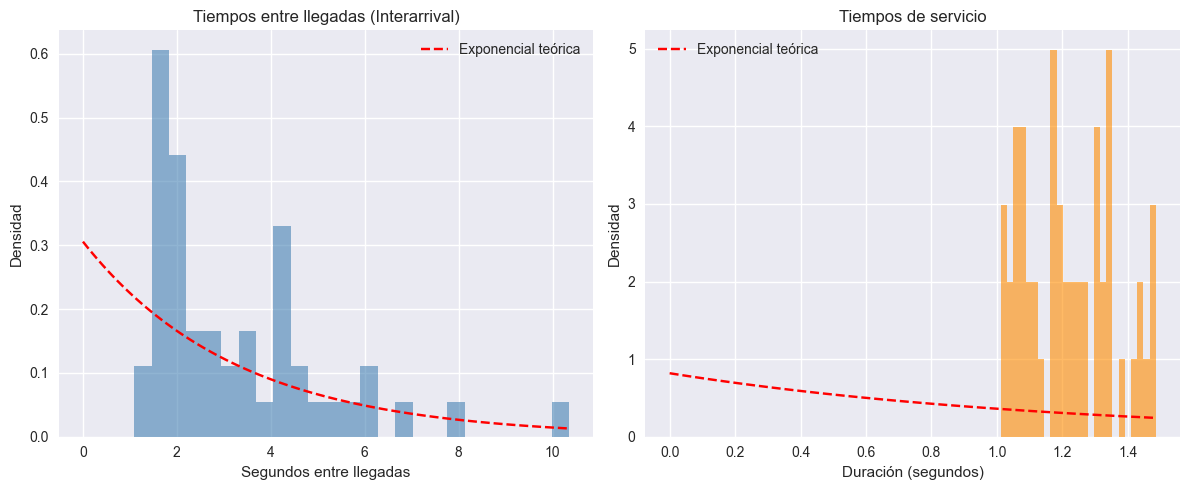

In [13]:
plt.figure(figsize=(12,5))

# Interarrival
plt.subplot(1, 2, 1)
plt.hist(interarrival, bins=25, density=True, alpha=0.6, color='steelblue')
x = np.linspace(0, interarrival.max(), 100)
plt.plot(x, expon.pdf(x, scale=interarrival.mean()), 'r--', label='Exponencial teórica')
plt.title("Tiempos entre llegadas (Interarrival)")
plt.xlabel("Segundos entre llegadas")
plt.ylabel("Densidad")
plt.legend()

# Service times
plt.subplot(1, 2, 2)
servicios = df_servicio["tiempo_servicio"].values
plt.hist(servicios, bins=25, density=True, alpha=0.6, color='darkorange')
x2 = np.linspace(0, servicios.max(), 100)
plt.plot(x2, expon.pdf(x2, scale=servicios.mean()), 'r--', label='Exponencial teórica')
plt.title("Tiempos de servicio")
plt.xlabel("Duración (segundos)")
plt.ylabel("Densidad")
plt.legend()

plt.tight_layout()
plt.show()
